In [ ]:
!pip install umap-learn rdkit

In [5]:
import numpy as np
import pandas as pd

import shutil
import os
import zipfile

from scipy.stats import entropy

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

#from transformers import AutoTokenizer, AutoModel
import torch
#import umap

from IPython.display import display
import dask.dataframe as dd
from io import BytesIO

### DATA Loading ###

In [ ]:
zip_file_path = 'BindingDB_All_202409_tsv.zip'
file_path = 'BindingDB_All.tsv'

list_columns_kept = ['Ligand SMILES', 'Target Name', 'Target Source Organism According to Curator or DataSource', 'Target Name', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)', 'pH', 'Temp (C)', 
                'Number of Protein Chains in Target (>1 implies a multichain complex)', 'BindingDB Target Chain Sequence', 'BindingDB Target Chain Sequence.1',
                'BindingDB Target Chain Sequence.2', 'BindingDB Target Chain Sequence.3', 'BindingDB Target Chain Sequence.4', 'BindingDB Target Chain Sequence.5',
                'BindingDB Target Chain Sequence.6', 'BindingDB Target Chain Sequence.7', 'BindingDB Target Chain Sequence.8', 'BindingDB Target Chain Sequence.9', 
                'BindingDB Target Chain Sequence.10', 'BindingDB Target Chain Sequence.11', 'BindingDB Target Chain Sequence.12']


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open('BindingDB_All.tsv') as file:
        data = pd.read_csv(file, sep='\t', usecols=list_columns_kept, na_values=['', 'NULL'])

data = pd.DataFrame(data)
data.head()

C:\Users\hudrya\AppData\Local\Temp\ipykernel_8928\3328271237.py:13: DtypeWarning: Columns (8,9,10,11,12,13,15,50,62,74,86,98,110,122,134,146,158,170,182) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file, sep='\t', usecols=list_columns_kept, na_values=['', 'NULL'])


,Ligand SMILES,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),kon (M-1-s-1),koff (s-1),pH,Temp (C),Number of Protein Chains in Target (>1 implies a multichain complex),BindingDB Target Chain Sequence,BindingDB Target Chain Sequence.1,BindingDB Target Chain Sequence.2,BindingDB Target Chain Sequence.3,BindingDB Target Chain Sequence.4,BindingDB Target Chain Sequence.5,BindingDB Target Chain Sequence.6,BindingDB Target Chain Sequence.7,BindingDB Target Chain Sequence.8,BindingDB Target Chain Sequence.9,BindingDB Target Chain Sequence.10,BindingDB Target Chain Sequence.11,BindingDB Target Chain Sequence.12
0,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.24,NaN,NaN,NaN,NaN,NaN,5.5,37.00 C,1,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.25,NaN,NaN,NaN,NaN,NaN,5.5,37.00 C,1,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.41,NaN,NaN,NaN,NaN,NaN,5.5,37.00 C,1,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.8,NaN,NaN,NaN,NaN,NaN,5.5,37.00 C,1,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.99,NaN,NaN,NaN,NaN,NaN,5.5,37.00 C,1,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Some Insight on Data ###

In [ ]:
# Get the value counts in the organism column
col_name = 'Target Source Organism According to Curator or DataSource'
if col_name in data.columns:
    value_counts = data.groupby(col_name).size().sort_values(ascending=False)
print(value_counts)

Target Source Organism According to Curator or DataSource
Homo sapiens                                        1541025
Rattus norvegicus                                    109758
Mus musculus                                          49854
Rattus                                                33718
Human immunodeficiency virus 1                        21780
                                                     ...   
Aeromonas allosaccharophila                               1
Human cytomegalovirus                                     1
Burkholderia cenocepacia                                  1
Maedi visna virus (strain 1514 / clone LV1-1KS2)          1
Hepatitis C virus genotype 4a (isolate ED43)              1
Length: 329, dtype: int64


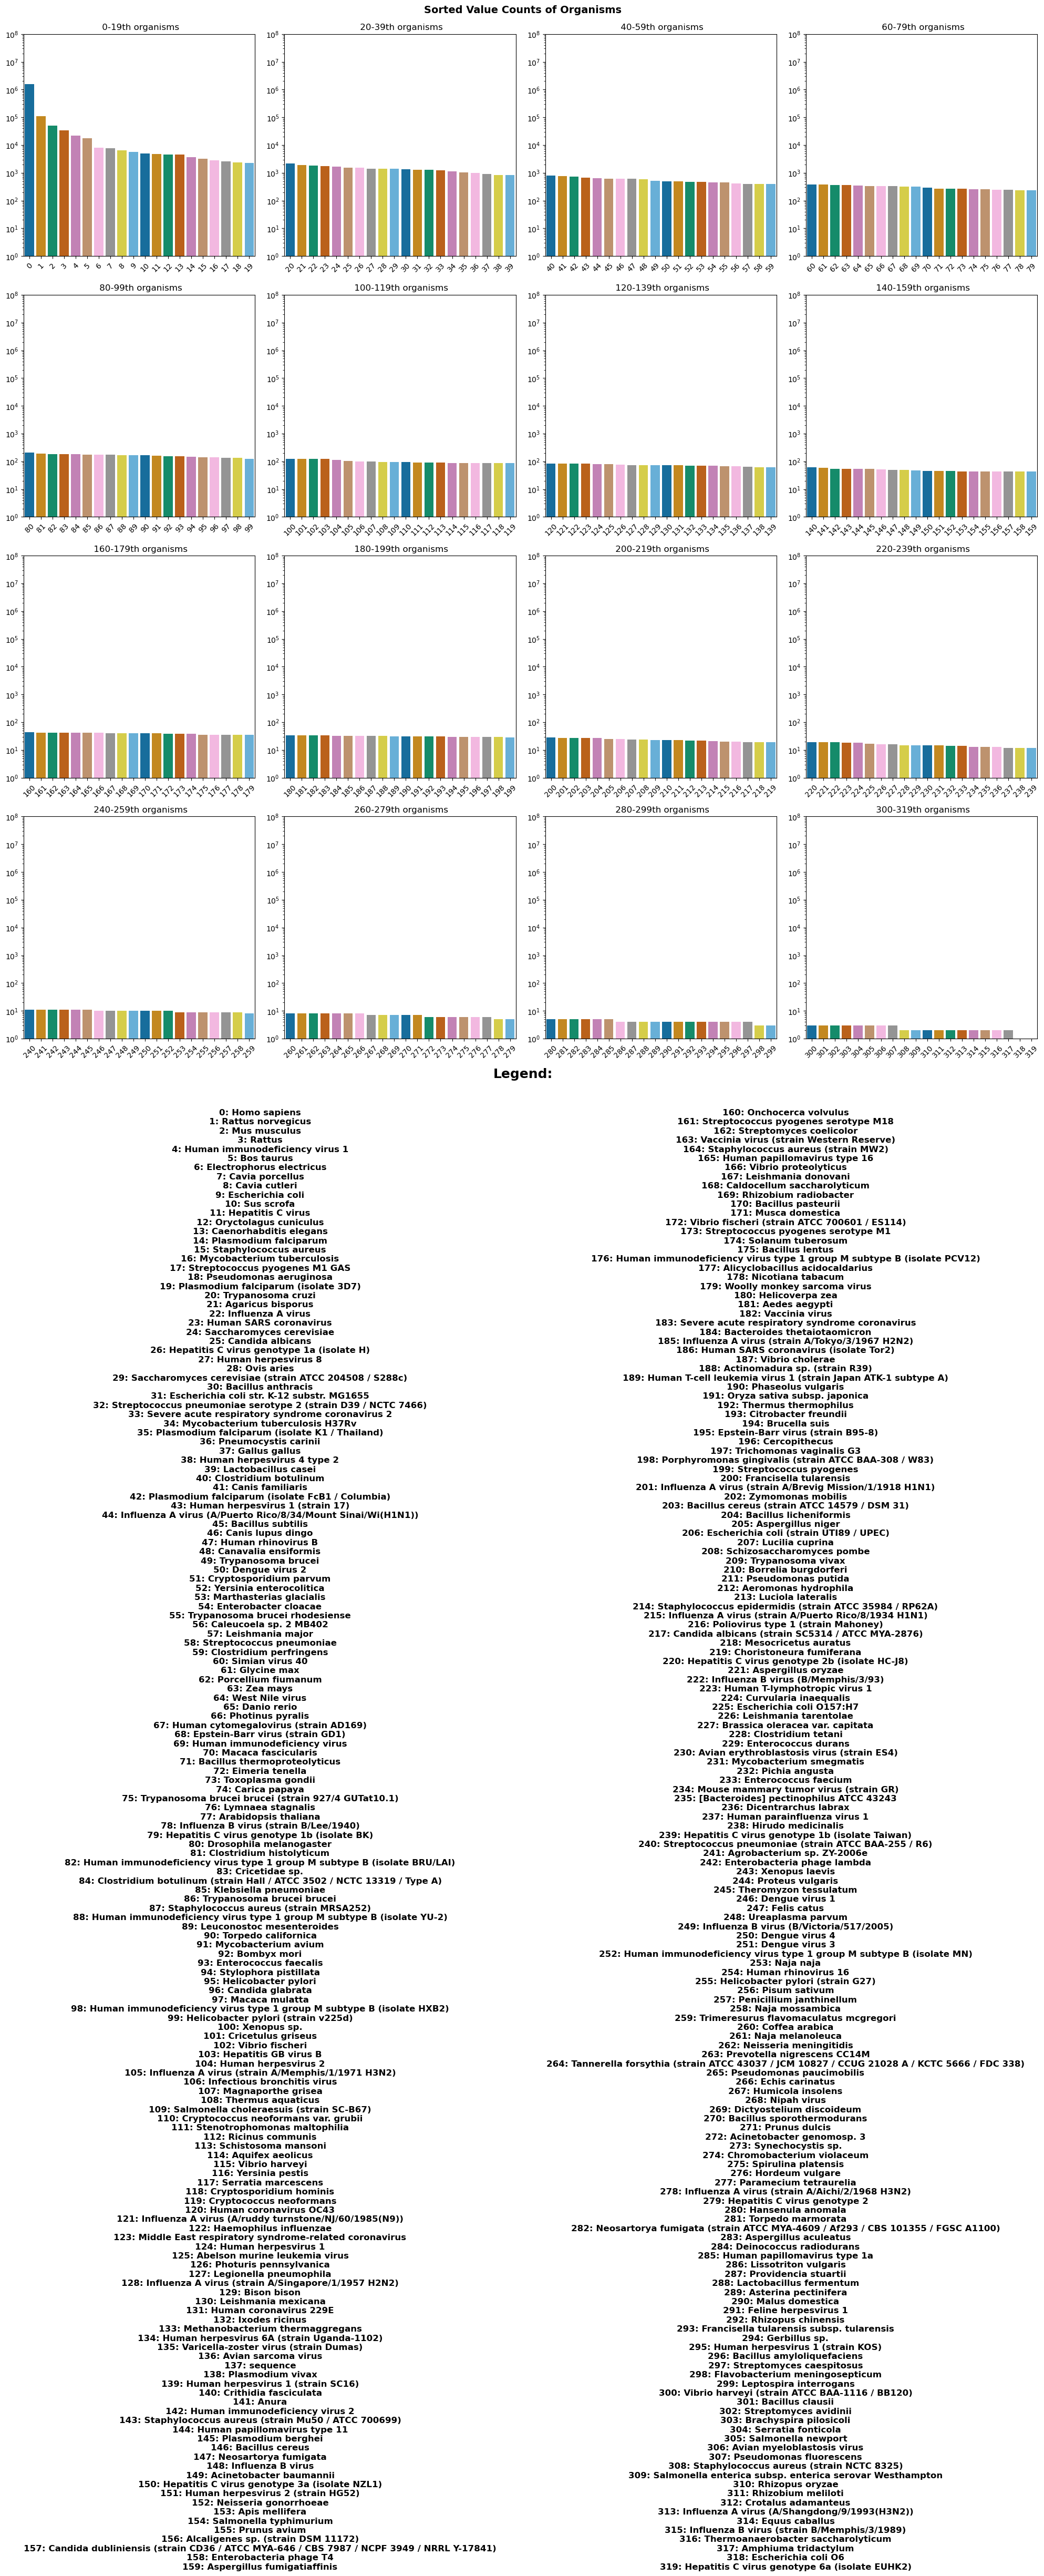

In [16]:
# Plot the sorted values counts of every organisms

palette = sns.palettes.color_palette('colorblind',n_colors=320)
fig, axes = plt.subplots(ncols=4,nrows=4, figsize=(20,20))

categories = value_counts.index
category_to_num = {category: i for i, category in enumerate(categories)}
num_to_category = {v: k for k, v in category_to_num.items()}
value_counts_num = value_counts.rename(index=category_to_num)

for num, ax in enumerate(axes.flatten()):
    x = value_counts_num.iloc[20*num:20*(num+1)]
    sns.barplot(x=x.index,y=x.values,hue=x.index,legend=False, palette=palette[20*num:20*(num+1)],ax=ax)
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.set_yscale('log')
    ax.set_ylim((1,10e7))
    ax.set_title(f' {20*num}-{20*(num+1) - 1}th organisms')
    ax.set_xlabel('')

num_to_category = {i: f"Category {i}" for i in range(1, 42)} 

categories = [f"{num}: {category}" for num, category in enumerate(categories[:320])]
n_columns = 2 
split_categories = [categories[i:i + len(categories)//n_columns] for i in range(0, len(categories), len(categories)//n_columns)]

plt.figtext(0.5,-0.001,'Legend:', ha='center', va='top', fontsize=18, fontweight=800)

y_position = -0.04 
for col, column in enumerate(split_categories):
    plt.figtext(0.5 + (col - 0.5) * 0.5, y_position, '\n'.join(column), ha='center', va='top', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.suptitle('Sorted Value Counts of Organisms', fontweight='bold', fontsize=14, y=1.01)
plt.savefig("number_in_org.png", facecolor="white", bbox_inches="tight")

In [18]:
#metric analysis to find which one between Ki and Kd are mostly present values in the dataset
non_nan_ki = data['Ki (nM)'].count()
print('Numbers of data containing Ki information: ', non_nan_ki)

non_nan_kd = data['Kd (nM)'].count()
print('Numbers of data containing Kd information: ', non_nan_kd)

Numbers of data containing Ki information:  591908
Numbers of data containing Kd information:  110827


### Focusing on Hiv1 ###

In [22]:
df_cleaned = data.dropna(subset= ['Ligand SMILES', 'Target Name', 'Target Source Organism According to Curator or DataSource', 'Ki (nM)'], how = 'any')
df_cleaned.reset_index()
df_cleaned.sample(5)

,Ligand SMILES,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),kon (M-1-s-1),koff (s-1),pH,Temp (C),Number of Protein Chains in Target (>1 implies a multichain complex),BindingDB Target Chain Sequence,BindingDB Target Chain Sequence.1,BindingDB Target Chain Sequence.2,BindingDB Target Chain Sequence.3,BindingDB Target Chain Sequence.4,BindingDB Target Chain Sequence.5,BindingDB Target Chain Sequence.6,BindingDB Target Chain Sequence.7,BindingDB Target Chain Sequence.8,BindingDB Target Chain Sequence.9,BindingDB Target Chain Sequence.10,BindingDB Target Chain Sequence.11,BindingDB Target Chain Sequence.12
1816325,CC(C)[C@H](NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C...,Disks large homolog 4,Homo sapiens,940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,MDCLCIVTTKKYRYQDEDTPPLEHSPAHLPNQANSPPVIVNTDTLE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
365595,C[C@@H](Cc1ccccc1)NC[C@H](O)c1cc(O)cc(O)c1,Beta-1 adrenergic receptor,Rattus norvegicus,31324,NaN,NaN,NaN,NaN,NaN,7.8,4.00 C,1,MGAGALALGASEPCNLSSAAPLPDGAATAARLLVLASPPASLLPPA...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1938598,CCc1cnn(c1)[C@H]1C[C@H]([C@H](O)[C@@H]1O)n1cnc...,Adenosine receptor A2a,Homo sapiens,182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,MPIMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVV...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2342370,Cc1nc2cnc3[nH]ccc3c2n1[C@H]1CC[C@@H](CC1)NCCC#N,Tyrosine-protein kinase JAK1,Homo sapiens,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,MQYLNIKEDCNAMAFCAKMRSSKKTEVNLEAPEPGVEVIFYLSDRE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
438370,CCOc1ccc(C)nc1C(=O)N1C2CCC1C(C2)Nc1ncc(cn1)C(F...,Orexin/Hypocretin receptor type 1,Rattus norvegicus,>10000,NaN,NaN,NaN,NaN,NaN,NaN,4.00 C,1,MEPSATPGAQPGVPTSSGEPFHLPPDYEDEFLRYLWRDYLYPKQYE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Choosing the metric which is the most present
metric = 'Ki (nM)'

# Filter for Hiv1
hiv_data = data[data['Target Source Organism According to Curator or DataSource'] == 'Human immunodeficiency virus 1'].reset_index(drop=True)
print(f'prior size: {hiv_data.shape[0]}')

mask_invalid_values = hiv_data[metric].str.contains('<',case=False,na=False) | hiv_data[metric].str.contains('>',case=False,na=False) | hiv_data[metric].isna()
print(f'final size: {hiv_data.shape[0] - mask_invalid_values.sum()}')
hiv_data = hiv_data[~mask_invalid_values]

prior size: 21780
final size: 4171


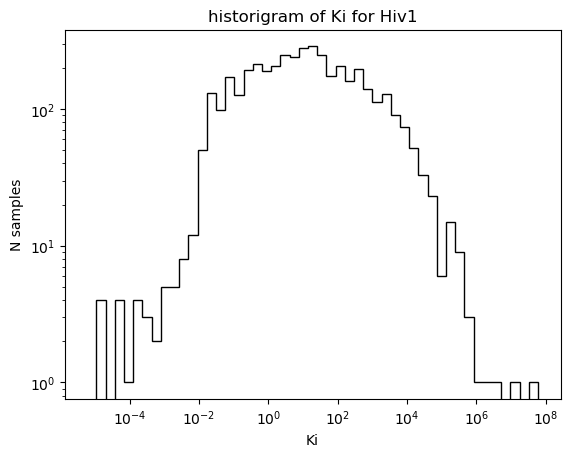

In [29]:
# Check metric distribution
valid_K_numeric = pd.to_numeric(hiv_data[metric], errors='coerce').dropna()
bins = np.logspace(np.log10(valid_K_numeric.min()), np.log10(valid_K_numeric.max()), 50)
plt.hist(valid_K_numeric, bins=bins, edgecolor="black", histtype="step", log=True)

plt.xscale('log')
plt.title('historigram of Ki for Hiv1')
plt.xlabel('Ki')
plt.ylabel('N samples')
plt.show()

Number of targets of the compounds in HIV1:  5638


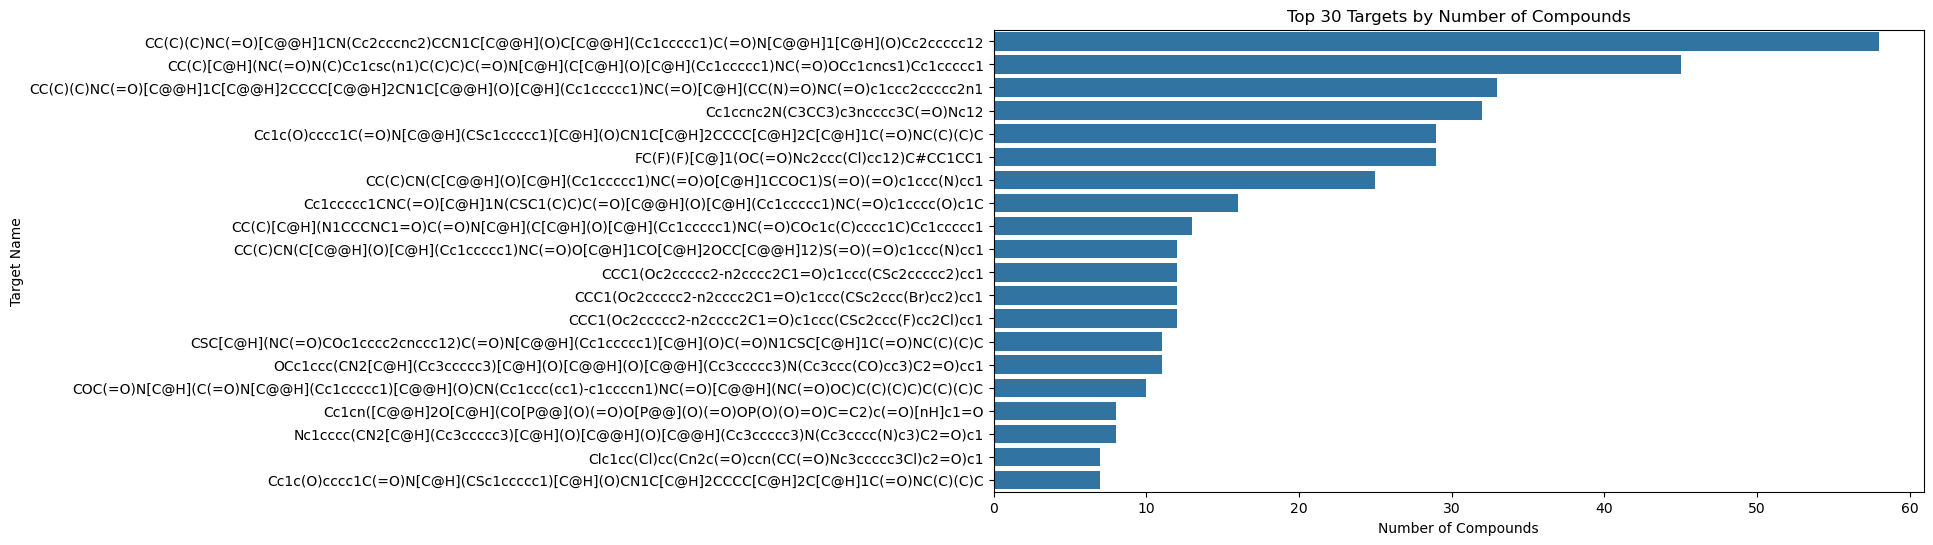

In [39]:
# Check the Ligand for Hiv1
target_counts = hiv_data.groupby('Ligand SMILES').size().reset_index(name='Compound Count')

target_counts = target_counts.sort_values(by='Compound Count', ascending=False)
print('Number of targets of the compounds in HIV1: ', target_counts.size)

plt.figure(figsize=(12, 6))
sns.barplot(x='Compound Count', y='Ligand SMILES', data=target_counts.head(20))
plt.title('Top 30 Targets by Number of Compounds')
plt.xlabel('Number of Compounds')
plt.ylabel('Target Name')
plt.show()

Number of targets of the compounds in HIV1:  126


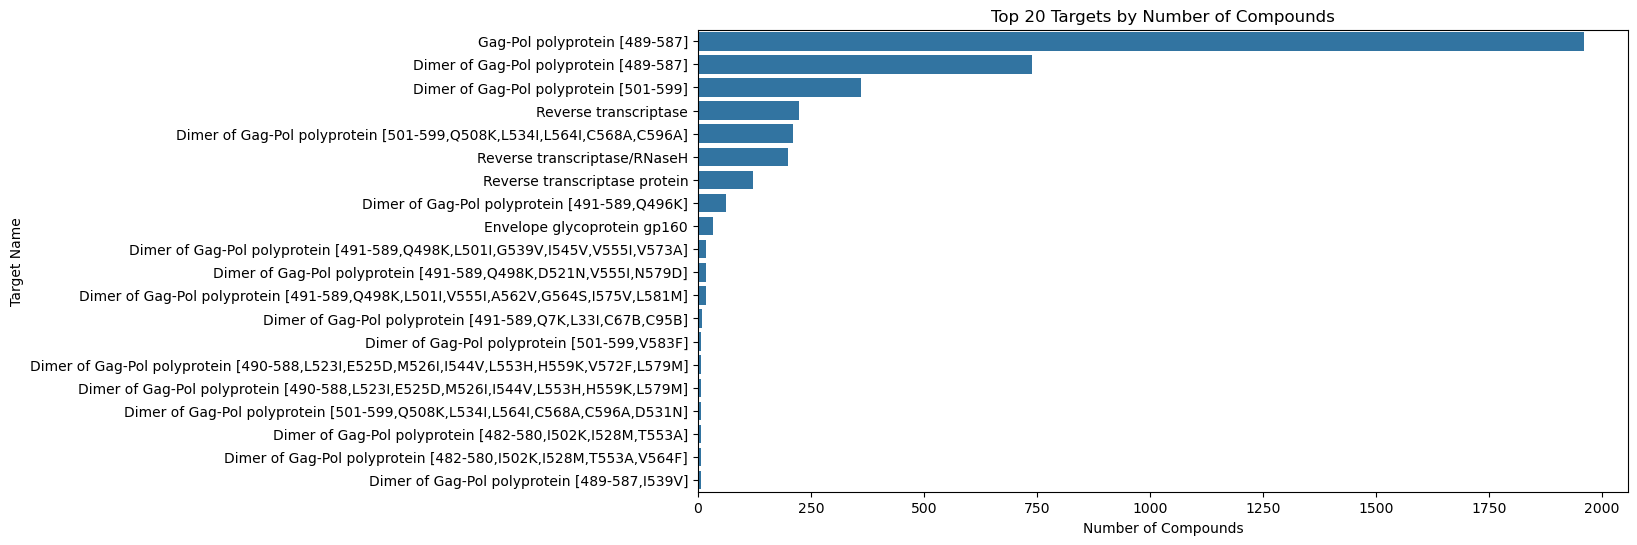

In [ ]:
# Check the targets for Hiv1
target_counts = hiv_data.groupby('Target Name').size().reset_index(name='Compound Count')

target_counts = target_counts.sort_values(by='Compound Count', ascending=False)
print('Number of targets of the compounds in HIV1: ', target_counts.size)

plt.figure(figsize=(12, 6))
sns.barplot(x='Compound Count', y='Target Name', data=target_counts.head(20))
plt.title('Top 20 Targets by Number of Compounds')
plt.xlabel('Number of Compounds')
plt.ylabel('Target Name')
plt.show()

In [ ]:
# Checking the Number of chains in Target
col_name = 'Number of Protein Chains in Target (>1 implies a multichain complex)'
if col_name in hiv_data.columns:
    count_Nchain = hiv_data.groupby(col_name).size().sort_values(ascending=False)
count_Nchain

Number of Protein Chains in Target (>1 implies a multichain complex)
1    4145
2      26
dtype: int64

In [ ]:
# To keep?
chain_over2 = hiv_data[hiv_data['Number of Protein Chains in Target (>1 implies a multichain complex)'].astype(float)>1]
chain_nums = chain_over2.index
for num in chain_nums:
    print(f'primary chain lenght: {len(chain_over2.loc[num]["BindingDB Target Chain Sequence"])}, secondary chain lenght: {len(chain_over2.loc[num]["BindingDB Target Chain Sequence.1"])}')

primary chain lenght: 1435, secondary chain lenght: 440
primary chain lenght: 1435, secondary chain lenght: 440
primary chain lenght: 1435, secondary chain lenght: 440
primary chain lenght: 1435, secondary chain lenght: 440
primary chain lenght: 1435, secondary chain lenght: 440
primary chain lenght: 560, secondary chain lenght: 440
primary chain lenght: 560, secondary chain lenght: 440
primary chain lenght: 560, secondary chain lenght: 440
primary chain lenght: 560, secondary chain lenght: 440
primary chain lenght: 560, secondary chain lenght: 440
primary chain lenght: 560, secondary chain lenght: 440
primary chain lenght: 560, secondary chain lenght: 440
primary chain lenght: 560, secondary chain lenght: 440
primary chain lenght: 560, secondary chain lenght: 440
primary chain lenght: 560, secondary chain lenght: 440
primary chain lenght: 560, secondary chain lenght: 440
primary chain lenght: 560, secondary chain lenght: 440
primary chain lenght: 560, secondary chain lenght: 440
prima

# Clustering with TNSE

#### Morgan fingerprints ####

In [ ]:
def generate_fingerprints(smiles_list, radius=2, n_bits=1024):
    """Generates Morgan fingerprints for a list of SMILES strings using MorganGenerator."""
    generator = GetMorganGenerator(radius=radius, fpSize=n_bits)  
    fingerprints = []
    
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = generator.GetFingerprint(mol)
            arr = np.zeros((1,), dtype=int)
            AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
            fingerprints.append(arr)
        else:
            fingerprints.append(None)
    
    return np.array([fp for fp in fingerprints if fp is not None])